# Assignment 2.1: Learner modeling - AI in Education, ETH Zurich

Intelligent tutoring systems are a popular approach for providing learners an opportunity to solve tasks and problems using learning-by-doing principles. These systems track data about the sequences of student interactions and based on this information, provide individualized feedback adapted to the level of student understanding.

An important part of this task is to be able to model learner performance, estimate the current state of a learner's knowledge and predict their future performance. Such models are called **Knowledge Tracing** models in the EDM literature. 

## Goal of Knowledge Tracing
The goal is to model the performance of learners as they interact with a learning system. 

In its simplest form, this can be formalized as a supervised sequence learning task - given a learner's history of past interactions with a learning system $(x_1, ..., x_t)$, predict some aspect of learner's next interaction $x_{t+1}$. In the case of a tutoring system, the $t$-th interaction is a tuple $x_t = (q_t, a_t)$, where $q_t$ is question that the learner attempts and $a_t$ is the binary correctness of the learner's answer.  
We predict the probability of learner answering next question correctly $p(a_{t+1} = 1 | q_{t+1}, x_{1:t})$.

In the dataset we are going to use, each interaction includes a set of knowledge components (KC) tags involved in the the question. A knowledge component is a label provided by teachers / instructors which specifies which knowledge is needed to solve a question. 

Example: Question of `16 / 4` might be categorized in the knowledge component of `whole number division`. 

Please note that we will use different terms - question, item, problem type - to refer to the problem solved by learners.

Knowledge tracing assumes that the probability of answering question $q$ that involves knowledge component $k$ (sometimes referred to as a skill) correctly depends on the learner's mastery of knowledge component $k$. Typically, different knowledge tracing models (encoding various assumptions about learning) are fit to the data and their comaprative fit can be evaluated. For a more detailed overview of knowldege components, please refer to knowledge-learning-instruction (KLI) theoretical framework (Koedinger 2012). 

## Models
The most commonly used approaches for knowledge tracing tasks are:
- **Bayesian Knowledge Tracing (BKT)** (Corbett and Anderson 1994)
- **Additive Factors Model (AFM)** (Cenn et al. 2009)
- **Performance Factor Analysis (PFA)** (Pavlik et al. 2009)
- **Deep Knowledge Tracing (DKT)** (Piech et al. 2015)

## Dataset
In this assignment we are going to work with subsets of the following dataset:
- [Assistment 2017 challenge](https://sites.google.com/view/assistmentsdatamining/dataset)

## Learning objectives
- Get hands on experience with datasets of student logged interactions from an educational system.
- Compare 5 different knowledge tracing models (BKT, BKT+forgetting, AFM, PFA, DKT) in terms of AUC, RMSE and area under precision-recall curve evaluation metrics.
- Report suggestions for teachers based on the analysis of model outputs and model parameters.

## Resources
- [pyBKT paper](https://educationaldatamining.org/EDM2021/virtual/static/pdf/EDM21_paper_237.pdf)
- [pyBKT library](https://github.com/CAHLR/pyBKT)
- [pyAFM library](https://github.com/cmaclell/pyAFM)

## Important
Please set your seed to the constant `SEED` everywhere random seed is used - this is crucial for reproducibility.

If you have any questions, please post them on the Moodle discussion forum.

Please note that some model fittings might require longer running times (several minutes on Apple Macbook 13' Pro 2016). Consider not using the full dataset when developing your solution.

## Instructions
- Please use cells which are marked as `ADD CODE HERE` for writing code for your answer. If you need more cells, you are free to create more.
- You can use anything available in the Python ecosystem, however you need to justify the usage of any additional library or component. 
- Use meaningful variable names and document your code.
- For each solution, provide textual description of your approach with explanations. If you used any assumptions, please document it.
- Submit only this single notebook (do not use additional python scripts) where all cells are executed (with output).

In [1]:
# Install pyBKT using pip
!pip install pyBKT

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 32.7 MB 221 kB/s 
  Created wheel for pyBKT: filename=pyBKT-1.4-cp37-cp37m-linux_x86_64.whl size=1024750 sha256=836af7641f8801c1a55c0a112303fd25e63b39e072c049161124b63ce8952943
  Stored in directory: /root/.cache/pip/wheels/d4/bb/83/0fe92b544252ddb34ad6bf4fd2659abd64140612b2d418cd07
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=50f59888b238df54da4f9b0354f63339787bd9513c3d176b6d896a13db6d6106
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built pyBKT sklearn


In [2]:
# Install specific version of PyAFMs using pip
!pip install git+https://github.com/cmaclell/pyAFM@6150afdef7ab2eabff6c439accb5f9f81af34129

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cmaclell/pyAFM (to revision 6150afdef7ab2eabff6c439accb5f9f81af34129) to /tmp/pip-req-build-pysrb9gl
  Running command git clone -q https://github.com/cmaclell/pyAFM /tmp/pip-req-build-pysrb9gl
  Running command git rev-parse -q --verify 'sha^6150afdef7ab2eabff6c439accb5f9f81af34129'
  Running command git fetch -q https://github.com/cmaclell/pyAFM 6150afdef7ab2eabff6c439accb5f9f81af34129
  Created wheel for pyafm: filename=pyafm-0.1.0-py3-none-any.whl size=15145 sha256=eaf21065a10fb86c6887d3057736c9d1e6c2501cddfbac1144f35aee38d485e5
  Stored in directory: /root/.cache/pip/wheels/8f/16/0c/ba6fe55038af4d5547c6757bfb69795a121a6301ae5f8c65f0
Successfully built pyafm


In [3]:
# Import common data science libraries
import numpy as np
import pandas as pd
import scipy as sc
import matplotlib.pyplot as plt
from typing import List, Dict, Any
from pyBKT.models import Model
from pyafm.custom_logistic import CustomLogistic
import tensorflow as tf

# IMPORTANT: please use this constant as a seed everywhere for reproducibility
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# ADD CODE HERE - import of any additional libraries
import seaborn as sns
import matplotlib.pyplot as plt

## Load Assistment 2017 Dataset
We are going to use dataset from Assistment tutoring system, the [Assistment 2017 dataset](https://sites.google.com/view/assistmentsdatamining/dataset). [ASSiSTment](https://www.commonsense.org/education/website/assistments) is a system for assigning and asessing math problems to students. Teachers select problems that students can complete. The student interface contains hints and immediate feedback. The original dataset has nearly 1M interactions from 1708 learners. In this assignment, we are going to use a subset of the data.

Refer to the [official descriptions of the variables](https://docs.google.com/spreadsheets/d/1QVUStXiRerWbH1X0P11rJ5IsuU2Xutu60D1SjpmTMlk/edit#gid=0). Please note the unique student id in the column with name `studentId` and is renamed to `user_id` during data loading. 

In [4]:
# Load dataset
DATASET = 'https://polybox.ethz.ch/index.php/s/C9YQPNADblf3G4Y/download'
dataset = pd.read_csv(DATASET, encoding = 'latin', low_memory = False)
dataset = dataset.rename(columns={"studentId": "user_id", "skill": "skill_name"}).drop("Unnamed: 0",axis=1)
dataset.head(5)

,user_id,MiddleSchoolId,InferredGender,SY ASSISTments Usage,AveKnow,AveCarelessness,AveCorrect,NumActions,AveResBored,AveResEngcon,...,RES_OFFTASK,RES_GAMING,Ln-1,Ln,MCAS,Enrolled,Selective,isSTEM,prior KC success,prior KC failure
0,8,2,Male,2004-2005,0.35242,0.18328,0.48390,1056,0.20839,0.67913,...,0.44027,0.00580,0.18500,0.55551,45,0,0,NaN,0,0
1,8,2,Male,2004-2005,0.35242,0.18328,0.48390,1056,0.20839,0.67913,...,0.88922,0.00580,0.41900,0.73761,45,0,0,NaN,0,0
2,8,2,Male,2004-2005,0.35242,0.18328,0.48390,1056,0.20839,0.67913,...,0.12259,0.00580,0.73761,0.91578,45,0,0,NaN,1,0
3,8,2,Male,2004-2005,0.35242,0.18328,0.48390,1056,0.20839,0.67913,...,0.12259,0.00580,0.91578,0.97673,45,0,0,NaN,2,0
4,8,2,Male,2004-2005,0.35242,0.18328,0.48390,1056,0.20839,0.67913,...,0.12259,0.00580,0.97673,0.99386,45,0,0,NaN,3,0


# Part 1: Exploratory analysis to understand the dataset
In the first part we are going to better understand the dataset.

In [ ]:
total_interactions = dataset.shape[0]
total_learners = dataset['user_id'].nunique()
total_question = dataset['problemId'].nunique()
total_kcs = dataset['skill_name'].nunique()
mean_kc_per_question = dataset.groupby("problemId").nunique()["skill_name"].mean()
median_questions_per_kc = dataset.groupby("skill_name").nunique()["problemId"].median()
median_learners_per_question = dataset.groupby("problemId").nunique()["user_id"].median()

dataset['startTimeDatetime'] = pd.to_datetime(dataset['startTime'], unit='s')
dataset['uniqueDateId'] = (dataset['startTimeDatetime'].dt.year.astype(str)+dataset['startTimeDatetime'].dt.month.astype(str)+dataset['startTimeDatetime'].dt.day.astype(str))

median_days_per_learner =  dataset.groupby("user_id").nunique()["uniqueDateId"].median()
median_interactions_per_learner = dataset.reset_index().groupby('user_id').nunique()["index"].median()

print("Total number of interactions: {}".format(total_interactions))
print("Total number of learners: {}".format(total_learners))
print("Total number of questions: {}".format(total_question))
print("Total number of knowledge components: {}".format(total_kcs))
print("Mean KC per question: {}".format(mean_kc_per_question))
print("Median question per KC: {}".format(median_questions_per_kc))
print("Median learners per question: {}".format(median_learners_per_question))
print("Median days per learner: {}".format(median_days_per_learner)) 
print("Median interactions per learner: {}".format(median_interactions_per_learner))

Total number of interactions: 26432
Total number of learners: 1354
Total number of questions: 89
Total number of knowledge components: 4
Mean KC per question: 1.0
Median question per KC: 22.0
Median learners per question: 105.0
Median days per learner: 3.0
Median interactions per learner: 16.0


### Q 1.1: Distributions of the number of interactions per learner
Plot a histogram of the number of interactions per learner (x-axis: number of interactions, y-axis: number of learners). Briefly describe the distribution (1-2 sentences).

19.52141802067947


(array([71., 56., 47., 35., 49., 46., 41., 38., 37., 48., 42., 43., 24.,
        39., 36., 28., 35., 31., 34., 29., 24., 31., 27., 33., 34., 25.,
        22., 23., 21., 23., 19., 20., 12., 12., 10., 17., 22., 13., 13.,
         8., 11.,  8.,  3., 12., 12., 10.,  5.,  5.,  2.,  3., 10.,  4.,
         1.,  3.,  6.,  7.,  2.,  3.,  5.,  4.,  2.,  1.,  1.,  1.,  1.,
         2.,  1.,  1.,  1.,  1.,  1.,  2.,  1.,  2.,  2.]),
 array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
        52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
        70, 73, 74, 78, 79, 80, 86, 88]),
 <a list of 75 Patch objects>)

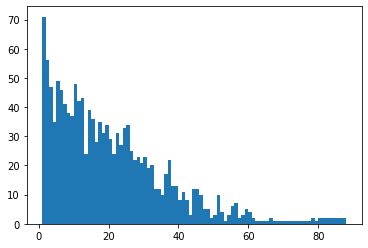

In [ ]:
# ADD CODE HERE
interaction_per_learner = dataset['user_id'].value_counts().to_numpy()
print(interaction_per_learner.mean())
interaction_hist = np.histogram(interaction_per_learner, bins = np.unique(interaction_per_learner))
plt.hist(interaction_hist[1][:-1], interaction_hist[1], weights=interaction_hist[0])

Answer:
* Most of *students* has from 0 to 40 interactions with the system. The median interactions per learn is 16, the average interactions per learner is 19.5.italicized text

### Q 1.2: Distribution of the knowledge components
Plot a histogram with the distribution of knowledge components. Briefly describe the distribution and the skills present in the dataset (1-2 sentences).

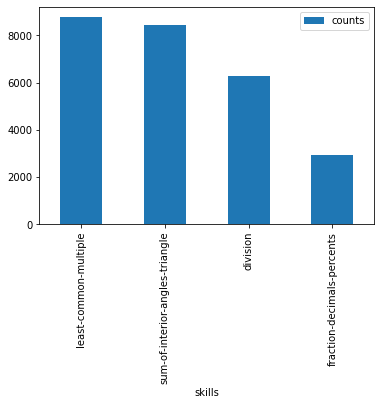

In [ ]:
# ADD CODE HERE
kc_df = dataset['skill_name'].value_counts().rename_axis('skills').reset_index(name='counts')
kc_df.plot.bar(x='skills', y='counts')

Answer:
* Fraction decimals percents is used less than other skills, least common multiple and sum of interior angles triangle are used more than other skills.

### Q1.3: Visualize interactions over time
The dataset contains timestamps of student interactions. Briefly answer the following questions (1-2 sentences each):
- Are there any differences in the practice intervals in which learning occurs for different skills? Support your answer with visualization.
- Why might it be important to consider time in knowledege tracing tasks? 

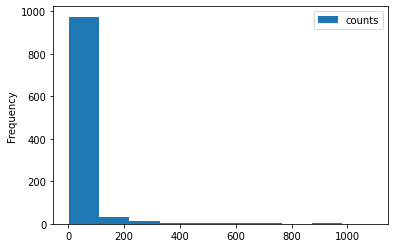

In [ ]:
# ADD CODE HERE
timetaken_df = dataset['timeTaken'].value_counts().rename_axis('timeTaken').reset_index(name='counts')
timetaken_df.plot.hist(x='timeTaken', y='counts')

([0, 1, 2, 3], <a list of 4 Text major ticklabel objects>)

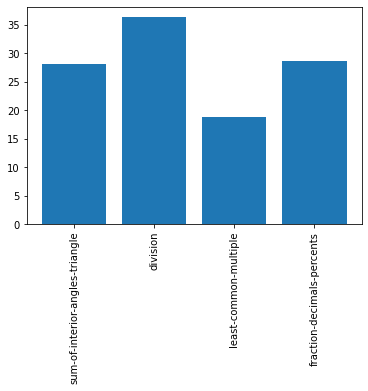

In [ ]:
# ADD CODE HERE
y = []
for skill in dataset['skill_name'].unique() :
  y.append(dataset[dataset['skill_name']==skill]['timeTaken'].mean())
plt.bar(x= dataset['skill_name'].unique() , height=y)
plt.xticks(rotation = 90)

Answer:
1. As shown in the histogram above, least common multiple uses less time than other skills. The division costs the most time span to finish.
2. Because longer timespan means the knowledge might be more difficult to handle compared with knowledge components with shorter timespan.

# Part 2: Fit models and compare evaluation metrics using cross-validation
- Work with the following models:
    - Model 1: BKT
    - Model 2: BKT+forgetting
    - Model 3: AFM
    - Model 4: PFA

Overview of tasks for this section:
- Perform student-based split into 3-folds, where each learner belongs to just one fold.
- Compare these models in terms of AUC, RMSE and area-under-precision-recall-curve on skills defined in the list `SKILLS` - Which model has the best performance? What is the difference between those models?
- Visualize resulting cross-validation metrics and their confidence intervals.

## Additive Factors Model (AFM) and Performance Factors Analysis (PFA) 
- The Additive Factors Model is a type of logistic regression model. 
- PFA (Pavlik et al. 2009) extends the idea of AFM by taking into account whether previous answers associated with a given KC were correct or incorrect. The model learns different learning rates for correct and wrong practice opportunities. 


In [6]:
# List of skills we are interested in
SKILLS =  ["sum-of-interior-angles-triangle", "division", "fraction-decimals-percents", "least-common-multiple"]

### Dataset split
To be consistent with the comparisons in the related literature, we would like to evaluate and compare models based on their ability to generalize to unseen learners. Therefore our goal is to perform a learner-based split - create 3-folds, where in each split interactions of the same student appear just in one fold. We are going to use the method `column_based_k_fold` to run 3-fold cross-validation at the learner level for all the models. 

In [ ]:
from sklearn import feature_extraction, model_selection, metrics

def column_based_k_fold(df: pd.DataFrame, by_column: str, nunber_of_splits: int = 3):
    """
    Splits dataset where same groups do not appear in two diverse folds.
    :param df:                Pandas Dataframe with learner interactions.
    :param by_column:         Which dataframe column to use for split, e.g. "item_id" for item-based split.
    :param number_of_splits:  Number of folds to create, cannot be less than 2. 
    :return:                  An iterator returning tuple of arrays of (training set indices, testing set indices)
    """
    X = np.arange(len(df)) 
    return model_selection.GroupKFold(n_splits=nunber_of_splits).split(X, groups=df[by_column].values)

In [ ]:
# Test usage - See example of method usage and expected output
test_df = pd.DataFrame({'group':['student_1', 'student_1', 'student_2', 'student_2'],
                        'interaction_id': [1, 2, 3, 4]})
for index, (train_index, test_index) in enumerate(column_based_k_fold(test_df, by_column="group", nunber_of_splits=2)):
    print("\nCross-validation iteration number: {}".format(index+1))
    train, test = test_df.iloc[train_index], test_df.iloc[test_index]
    print("Train set:")
    print(train)
    print("Test set:")
    print(test)


Cross-validation iteration number: 1
Train set:
       group  interaction_id
0  student_1               1
1  student_1               2
Test set:
       group  interaction_id
2  student_2               3
3  student_2               4

Cross-validation iteration number: 2
Train set:
       group  interaction_id
2  student_2               3
3  student_2               4
Test set:
       group  interaction_id
0  student_1               1
1  student_1               2


Please notice that interactions of one student belongs to just one unique fold - either train or test set in this case.

### Define our custom evaluation metric: area under precision recall curve

Precision-recall curves are typically used in binary classification to study the output of a classifier. When data is imbalanced, the AUC might not reflect the true performance of the classifier. When we care about minority class, e.g. in case of knowledge tracing (assuming correct response is minority class) we would like to focus on model being able to correctly predict when student will answer a question correctly if we are using the model for downstream task such as adaptivity to not pick questions / problem which are too easy for a student.

In [ ]:
from sklearn.metrics import average_precision_score, roc_auc_score, mean_squared_error

def area_under_precision_recall_curve(true_vals: np.ndarray, pred_vals: np.ndarray) -> float:
    return average_precision_score(true_vals, pred_vals)

y_true = np.array([0, 0, 1, 1])
y_scores = np.array([0.1, 0.4, 0.35, 0.8])
assert round(area_under_precision_recall_curve(y_true, y_scores)) == round(5/6)
def m_rmse(true_vals: np.ndarray, pred_vals: np.ndarray) -> float:
  return mean_squared_error(true_vals, pred_vals, squared = False)

Create variables for visualization of metrics (see Q2.7)

In [ ]:
# Store metric for each cross validation split in these variable
# Use these varaibles for storing AUC metrics
bkt_auc = [random.random() for _ in range(3)]
bkt_forgetting_auc = [random.random() for _ in range(3)]
afm_auc = [random.random() for _ in range(3)]
pfa_auc = [random.random() for _ in range(3)]

# Use these varaibles for storing RMSE metrics
bkt_rmse = [random.random() for _ in range(3)]
bkt_forgetting_rmse = [random.random() for _ in range(3)]
afm_rmse = [random.random() for _ in range(3)]
pfa_rmse = [random.random() for _ in range(3)]

# Use these varaibles for storing Average precision score metrics
bkt_ap = [random.random() for _ in range(3)]
bkt_forgetting_ap = [random.random() for _ in range(3)]
afm_ap = [random.random() for _ in range(3)]
pfa_ap = [random.random() for _ in range(3)]

### Q2.1 Train and evaluate `BKT` model
Use pyBKT library for training the BKT model. Compute evaluation metrics for each cross-validation iteration and log / print them for each iteration. Think about how to store these metrics for visualizations (Q2.7).

- Implement the cross-validation with BKT model training below
- Briefly describe (1-2 sentences): What happens when we call BKT `fit` method?

In [ ]:
BKT = Model(seed = SEED, parallel = True)
for cv_iteration, (train_indices, test_indices) in enumerate(column_based_k_fold(dataset, by_column="user_id", nunber_of_splits=3)):
    # YOUR CODE HERE
    print("------Fold {}-----".format(cv_iteration))

    train, test = dataset.iloc[train_indices], dataset.iloc[test_indices]
    BKT.fit(data = train, skills = SKILLS)
    training_rmse = BKT.evaluate(data=train, metric='rmse')
    training_auc = BKT.evaluate(data=train, metric='auc')
    training_ap = BKT.evaluate(data=train, metric=area_under_precision_recall_curve)
    bkt_rmse[cv_iteration] = BKT.evaluate(data=test, metric='rmse')
    bkt_auc[cv_iteration] = BKT.evaluate(data=test, metric='auc')
    bkt_ap[cv_iteration] = BKT.evaluate(data=test, metric=area_under_precision_recall_curve)
    
    
    print("Training RMSE: %f" % training_rmse)
    print("Training AUC: %f" % training_auc)
    print("Training AP: %f" % training_ap)
    print("Testing RMSE: %f" % bkt_rmse[cv_iteration])
    print("Testing AUC: %f" % bkt_auc[cv_iteration])
    print("Testing AP: %f" % bkt_ap[cv_iteration])


------Fold 0-----
Training RMSE: 0.459754
Training AUC: 0.721544
Training AP: 0.727538
Testing RMSE: 0.450586
Testing AUC: 0.745236
Testing AP: 0.770920
------Fold 1-----
Training RMSE: 0.454880
Training AUC: 0.735131
Training AP: 0.755801
Testing RMSE: 0.459904
Testing AUC: 0.724993
Testing AP: 0.720579
------Fold 2-----
Training RMSE: 0.453755
Training AUC: 0.736655
Training AP: 0.744958
Testing RMSE: 0.461823
Testing AUC: 0.714985
Testing AP: 0.724208


Answer:
* The BKT model is a use case of Hidden Markov Model. For each observation (interaction), the probability of the student u knows the knowledge k is updated by an update equation, and this probability will be used to compute the probability of getting a correct answer for the next interaction uses this knowledge. 

### Q2.2: Train and evaluate `BKT+forgetting` model
Use pyBKT library for training the BKT model with forgetting. Compute evaluation metrics for each cross-validation iteration and log / print them for each iteration. Think about how to store these metrics for future visualizations (Q 2.7).

In [ ]:
BKT = Model(seed = SEED, parallel = True)
for cv_iteration, (train_indices, test_indices) in enumerate(column_based_k_fold(dataset, by_column="user_id", nunber_of_splits=3)):
    # YOUR CODE HERE
    print("------Fold {}-----".format(cv_iteration))

    train, test = dataset.iloc[train_indices], dataset.iloc[test_indices]
    
    BKT.fit(data = train, skills = SKILLS, forgets=True)
    training_rmse = BKT.evaluate(data=train, metric='rmse')
    training_auc = BKT.evaluate(data=train, metric='auc')
    training_ap = BKT.evaluate(data=train, metric=area_under_precision_recall_curve)
    bkt_forgetting_rmse[cv_iteration] = BKT.evaluate(data=test, metric='rmse')
    bkt_forgetting_auc[cv_iteration] = BKT.evaluate(data=test, metric='auc')
    bkt_forgetting_ap[cv_iteration] = BKT.evaluate(data=test, metric=area_under_precision_recall_curve)
    
    
    print("Training RMSE: %f" % training_rmse)
    print("Training AUC: %f" % training_auc)
    print("Training AP: %f" % training_ap)
    print("Testing RMSE: %f" % bkt_forgetting_rmse[cv_iteration])
    print("Testing AUC: %f" % bkt_forgetting_auc[cv_iteration])
    print("Testing AP: %f" % bkt_forgetting_ap[cv_iteration])

------Fold 0-----
Training RMSE: 0.457458
Training AUC: 0.730276
Training AP: 0.744490
Testing RMSE: 0.449854
Testing AUC: 0.749728
Testing AP: 0.771269
------Fold 1-----
Training RMSE: 0.453248
Training AUC: 0.739999
Training AP: 0.763244
Testing RMSE: 0.459805
Testing AUC: 0.726126
Testing AP: 0.731889
------Fold 2-----
Training RMSE: 0.453070
Training AUC: 0.740343
Training AP: 0.754282
Testing RMSE: 0.458507
Testing AUC: 0.726751
Testing AP: 0.750512


### AFM and PFA model
In this section we are going to train models based on logistic regression.

We are going to use `pyAFM` package which contains a custom implmentation in the model `CustomLogistic()`. It is a customized logistic regression which allows to restrict the learning rates to be positive, under the assumption that practice can only improve the likelihood that a student will get a step correct. Secondly, it prevents overfitting by L2 regularization only on the student intercepts. 

#### Compute prior opportunities, prior KC successes and prior KC failures
We are going to add the following three columns to each row in the `dataframe` as additional features.
- `prior_opportunities` - number of previous opportunities of learner with the knowledge component of a question.
- `prior KC successes` - number of previously successfuly solved questions of learner with the knowledge component of a question.
- `prior KC failures` - number of previously unsuccessfuly solved questions of learner with the knowledge component of a question.


In [ ]:
# Compute prior opportunities, prior KC successes, prior KC failures (might be time-consuming and could be improved) - DO NOT CHANGE THE CODE
dataset["prior_opportunities"] = 0
dataset["prior KC successes"] = 0
dataset["prior KC failures"] = 0

# Create list of unique KCs and unique student IDs
knowledge_component_list = dataset['skill_name'].unique()
student_ids_list = dataset['user_id'].unique()
# Loop of all KCs
for kc_index in range(len(knowledge_component_list)):
    # Loop over all students
    for student_index in range(len(student_ids_list)):

        # Create temporary dataframes for different combinations
        df_tmp = dataset.loc[
            (dataset['user_id'] == student_ids_list[student_index]) & (dataset['skill_name'] == knowledge_component_list[kc_index])].copy()

        df_tmp.sort_values(by="startTime", inplace=True, key=pd.to_datetime)
        
        # Initialize counters for prior success and prior failure
        counter = 0
        correct = 0
        incorrect = 0
        for index, row in df_tmp.iterrows():
            dataset["prior_opportunities"].loc[index] = counter
            counter +=1
            dataset["prior KC successes"].loc[index] = correct
            dataset["prior KC failures"].loc[index] = incorrect
            if row['correct'] == 1:
                correct += 1
            else:
                incorrect += 1

In [ ]:
# Just a quick check
dataset[["user_id", "skill_name", "prior_opportunities", "correct", "prior KC successes", "startTime", "startTimeDatetime"]].head(10)

,user_id,skill_name,prior_opportunities,correct,prior KC successes,startTime,startTimeDatetime
0,8,sum-of-interior-angles-triangle,0,1,0,1097164867,2004-10-07 16:01:07
1,8,division,0,1,0,1098124282,2004-10-18 18:31:22
2,8,division,1,1,1,1098125162,2004-10-18 18:46:02
3,8,division,2,1,2,1098125306,2004-10-18 18:48:26
4,8,division,3,1,3,1098719927,2004-10-25 15:58:47
5,8,division,4,1,4,1098980116,2004-10-28 16:15:16
6,35,sum-of-interior-angles-triangle,0,0,0,1100526102,2004-11-15 13:41:42
7,35,sum-of-interior-angles-triangle,1,0,0,1100526182,2004-11-15 13:43:02
8,35,sum-of-interior-angles-triangle,2,1,0,1100526269,2004-11-15 13:44:29
9,35,sum-of-interior-angles-triangle,3,1,1,1100526408,2004-11-15 13:46:48


Let's use these columns to compute input and output features.

In [ ]:
# Adapted from pyAFM library - do not change the cell, if needed please document why
# pyAFM helpers to create input and output matrices

student_ids, knowledge_components, prior_opportunities, ground_truths = [], [], [], []
# Iterate over all data points and create dictionaries with features
for _, row in dataset.iterrows():
    student_id = row['user_id']
    knowledge_component = row['skill_name']
    correct = row['correct']
    prior_kc_opps = row["prior_opportunities"] 
    student_ids.append({student_id: 1})
    knowledge_components.append({knowledge_component: 1})
    prior_opportunities.append({knowledge_component: prior_kc_opps})
    ground_truths.append(correct)

# Use dictionaries to vectorize features
student_identity_matrix = feature_extraction.DictVectorizer().fit_transform(student_ids)
knowledge_component_identity_matrix = feature_extraction.DictVectorizer().fit_transform(knowledge_components)
student_kc_opportunities_matrix = feature_extraction.DictVectorizer().fit_transform(prior_opportunities)
X = sc.sparse.hstack((student_identity_matrix, 
                      knowledge_component_identity_matrix, 
                      student_kc_opportunities_matrix))
X = X.toarray()
y = np.array(ground_truths)

# Initialize l2 and bounds
l2 = [1.0 for i in range(student_identity_matrix.shape[1])]
l2 += [0.0 for i in range(knowledge_component_identity_matrix.shape[1])]
l2 += [0.0 for i in range(student_kc_opportunities_matrix.shape[1])]
bounds = [(None, None) for i in range(student_identity_matrix.shape[1])]
bounds += [(None, None) for i in range(knowledge_component_identity_matrix.shape[1])]
bounds += [(0, None) for i in range(student_kc_opportunities_matrix.shape[1])]

### Q2.3: Number of learnable parameters
Analyze the code above and matrices `student_identity_matrix`, `knowledge_component_identity_matrix`, `student_kc_opportunities_matrix`, `X` and `y`. 

Briefly describe:
- Describe idea of AFM model (2-3 sentences).
- How many learnable parameters does the model have? Use the code cell below to compute the answer.

Answer:
* The idea of AFM is actually logistic regression with feature engineering. AFM models the student's ability in parameter $\theta$, difficulty of the knowledge in parameter $\beta$, and occurence of the knowledge in past experience in parameter $\gamma$. Correspondingly, the features includes: student identity matrix to multiply with $\theta$, boolean matrix to identify whether the knowledge is used to multiply with $\beta$, and number of occurence of the knowledge to multiply with $\gamma$. 

In [ ]:
print("Number of parameters: " + str(student_identity_matrix.shape[1] + knowledge_component_identity_matrix.shape[1] + student_kc_opportunities_matrix.shape[1]))

Number of parameters: 1362


### Q2.4: Train and evaluate `AFM` model
Use `CustomLogistic` from pyAFM library for training the AFM model and use the input and output variables computed in the previous cells. Compute evaluation metrics for each cross-validation iteration and log / print them for each iteration. Think about how to store these metrics for future visualizations (Q 2.10).

- Implement the cross-validation with AFM model training below
- Briefly describe (1-2 sentences): What happens when we call `CustomLogistic` fit method? Take a look at the `custom_logistic.py` from the library `pyAFM` to understand better how the model is trained.

In [ ]:
# ADD CORE HERE

afm_model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)

for cv_iteration, (train_indices, test_indices) in enumerate(column_based_k_fold(dataset, by_column="user_id", nunber_of_splits=3)):
    # ADD CODE HERE
    # YOUR CODE HERE
    print("------Fold {}-----".format(cv_iteration))
    X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
    afm_model.fit(X = X_train, y = y_train)
    y_train_pred = afm_model.predict(X_train)
    y_test_pred = afm_model.predict(X_test)
    

    training_rmse = mean_squared_error(y_train, y_train_pred, squared = False)
    training_auc = roc_auc_score(y_train, y_train_pred)
    training_ap = area_under_precision_recall_curve(y_train, y_train_pred)
    afm_rmse[cv_iteration] = mean_squared_error(y_test, y_test_pred, squared = False)
    afm_auc[cv_iteration] = roc_auc_score(y_test, y_test_pred)
    afm_ap[cv_iteration] = area_under_precision_recall_curve(y_test, y_test_pred)
    
    
    print("Training RMSE: %f" % training_rmse)
    print("Training AUC: %f" % training_auc)
    print("Training AP: %f" % training_ap)
    print("Testing RMSE: %f" % afm_rmse[cv_iteration])
    print("Testing AUC: %f" % afm_auc[cv_iteration])
    print("Testing AP: %f" % afm_ap[cv_iteration])

------Fold 0-----
Training RMSE: 0.546151
Training AUC: 0.659274
Training AP: 0.535297
Testing RMSE: 0.650467
Testing AUC: 0.541123
Testing AP: 0.414624
------Fold 1-----
Training RMSE: 0.540353
Training AUC: 0.662195
Training AP: 0.535071
Testing RMSE: 0.645123
Testing AUC: 0.550902
Testing AP: 0.432040
------Fold 2-----
Training RMSE: 0.534318
Training AUC: 0.672120
Training AP: 0.546168
Testing RMSE: 0.648494
Testing AUC: 0.547579
Testing AP: 0.426307


Answer:
* The dot product between parameters $\theta, \beta, \gamma$ and the features student identity, knowledge identity, and number of occurrence is fitted into a sigmoid function and trained the same as logistic regression. 

### Performance Factor Analysis model
Similarly, in this part we are going to train and evalute PFA model.

In [ ]:
# Adapted from pyAFM library - do not change the cell, if needed please document why
# pyAFM helpers to create input and output matrices

student_ids, knowledge_components, ground_truths, prior_number_successes, prior_number_failures = [], [], [], [], []
# Iterate over all data points and create dictionaries with features
for _, row in dataset.iterrows():
    student_id = row['user_id']
    knowledge_component = row['skill_name']
    correct = row['correct']
    prior_successes = row["prior KC successes"] 
    prior_failures = row["prior KC failures"]

    student_ids.append({student_id: 1})
    knowledge_components.append({knowledge_component: 1})
    ground_truths.append(correct)
    prior_number_successes.append({knowledge_component: int(prior_successes)})
    prior_number_failures.append({knowledge_component: int(prior_failures)})

# Use dictionaries to vectorize features
student_identity_matrix = feature_extraction.DictVectorizer().fit_transform(student_ids)
knowledge_component_identity_matrix = feature_extraction.DictVectorizer().fit_transform(knowledge_components)
student_kc_prior_sucess_matrix = feature_extraction.DictVectorizer().fit_transform(prior_number_successes)
student_kc_prior_failure_matrix = feature_extraction.DictVectorizer().fit_transform(prior_number_failures)
X = sc.sparse.hstack((student_identity_matrix, knowledge_component_identity_matrix, 
                      student_kc_prior_sucess_matrix, student_kc_prior_failure_matrix))
X = X.toarray()
y = np.array(ground_truths)

# Initialize l2 and bounds
l2 = [1.0 for i in range(student_identity_matrix.shape[1])]
l2 += [0.0 for i in range(knowledge_component_identity_matrix.shape[1])]
l2 += [0.0 for i in range(student_kc_prior_sucess_matrix.shape[1])]
l2 += [0.0 for i in range(student_kc_prior_failure_matrix.shape[1])]
bounds = [(None, None) for i in range(student_identity_matrix.shape[1])]
bounds += [(None, None) for i in range(knowledge_component_identity_matrix.shape[1])]
bounds += [(0, None) for i in range(student_kc_prior_sucess_matrix.shape[1])]
bounds += [(0, None) for i in range(student_kc_prior_failure_matrix.shape[1])]

### Q2.5: Number of learnable parameters
Analyze the code above and matrices `student_identity_matrix`, `knowledge_component_identity_matrix`, `student_kc_prior_sucess_matrix`, `student_kc_prior_failure_matrix`, `X` and `y`. 

Briefly describe:
- Describe idea of PFA model (2-3 sentences).
- How many learnable parameters does the model have? What is the difference between AFM and PFA? Use the code cell below to compute the answer. 

Answer:
* PFA model is based on AFM, the difference is that it seperates the occurrence of the knowledge in the past experience ($γ$) into two parts: number of correct interaction modeled by $\gamma$ and number of incorrect interaction modeled by $\delta$. The intuition is that the correct and incorrect experience may have different influence on the learning of the knowledge. 

* The difference is that PFA separates the correct experience and incorrect experience. 

In [ ]:
# ADD CODE HERE
print("Number of parameters: " + str(student_identity_matrix.shape[1] + knowledge_component_identity_matrix.shape[1] + student_kc_prior_sucess_matrix.shape[1] * 2))

Number of parameters: 1366


### Q2.6: Train and evaluate `PFA` model
Use pyAFM library for training the PFA model using `CustomLogistic` model. Compute evaluation metrics for each cross-validation iteration and log / print them for each iteration. Think about how to store these metrics for future visualizations (Q 2.10).

In [ ]:
from pyafm.custom_logistic import CustomLogistic

pfa_model = CustomLogistic(bounds=bounds, l2=l2, fit_intercept=False)

for cv_iteration, (train_indices, test_indices) in enumerate(column_based_k_fold(dataset, by_column="user_id", nunber_of_splits=3)):
    print("------Fold {}-----".format(cv_iteration))
    X_train, X_test, y_train, y_test = X[train_indices], X[test_indices], y[train_indices], y[test_indices]
    pfa_model.fit(X = X_train, y = y_train)
    y_train_pred = pfa_model.predict(X_train)
    y_test_pred = pfa_model.predict(X_test)
    

    training_rmse = mean_squared_error(y_train, y_train_pred, squared = False)
    training_auc = roc_auc_score(y_train, y_train_pred)
    training_ap = area_under_precision_recall_curve(y_train, y_train_pred)
    pfa_rmse[cv_iteration] = mean_squared_error(y_test, y_test_pred, squared = False)
    pfa_auc[cv_iteration] = roc_auc_score(y_test, y_test_pred)
    pfa_ap[cv_iteration] = area_under_precision_recall_curve(y_test, y_test_pred)
    
    
    print("Training RMSE: %f" % training_rmse)
    print("Training AUC: %f" % training_auc)
    print("Training AP: %f" % training_ap)
    print("Testing RMSE: %f" % pfa_rmse[cv_iteration])
    print("Testing AUC: %f" % pfa_auc[cv_iteration])
    print("Testing AP: %f" % pfa_ap[cv_iteration])

------Fold 0-----
Training RMSE: 0.544016
Training AUC: 0.664204
Training AP: 0.538476
Testing RMSE: 0.628910
Testing AUC: 0.577276
Testing AP: 0.438531
------Fold 1-----
Training RMSE: 0.539302
Training AUC: 0.665830
Training AP: 0.536793
Testing RMSE: 0.630172
Testing AUC: 0.581664
Testing AP: 0.452419
------Fold 2-----
Training RMSE: 0.529249
Training AUC: 0.679023
Training AP: 0.553279
Testing RMSE: 0.636481
Testing AUC: 0.573599
Testing AP: 0.443091


### Visualize all metrics using bar plot with confidence intervals
Bar plot visualizing all metrics (RMSE, AUC, AP) for each model. The code compute your final results as the mean over all cross-validation splits for each model. Visualization contains confidence intervals to measure variance across results per fold. 
 
Hint: Don't forget to store all cross-validation results for each split in an array. 

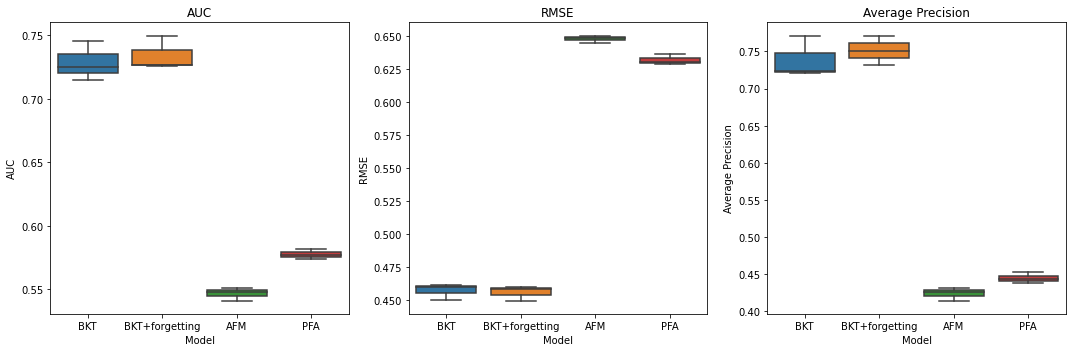

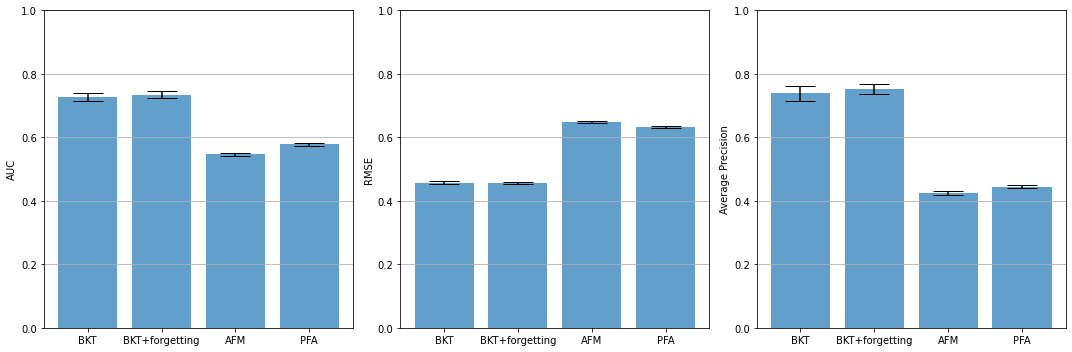

In [ ]:
import seaborn as sns

# Fill all the variables in previous questions
metrics = {'AUC': {'BKT': bkt_auc, 'BKT+forgetting': bkt_forgetting_auc, 'AFM': afm_auc, 'PFA': pfa_auc}, 
           'RMSE': {'BKT': bkt_rmse, 'BKT+forgetting': bkt_forgetting_rmse, 'AFM': afm_rmse, 'PFA': pfa_rmse},
           'Average Precision': {'BKT': bkt_ap, 'BKT+forgetting': bkt_forgetting_ap, 'AFM': afm_ap, 'PFA': pfa_ap}}

plt.figure(figsize=(15, 5))

for index, metric_key in enumerate(metrics.keys()):

    plt.subplot(1, len(metrics), index + 1)
    plt.title(metric_key)
    sns.boxplot(x='variable', y='value', data=pd.melt(pd.DataFrame(metrics[metric_key])))
    plt.ylabel(metric_key)
    plt.xlabel('Model')

plt.tight_layout()
plt.show()


plt.figure(figsize=(15, 5))
for index, metric_key in enumerate(metrics.keys()):
    plt.subplot(1, len(metrics), index + 1)
    means, errors, labels = [], [], []
    for model_key, model_scores in metrics[metric_key].items():
        means.append(np.mean(model_scores))
        errors.append(np.std(model_scores))
        labels.append(model_key)
    x_pos = np.arange(len(labels))
    plt.bar(x_pos, means, yerr=errors, align='center', alpha=0.7, ecolor='black', capsize=15)
    plt.grid(axis='y')
    plt.xticks(x_pos, labels)
    plt.ylabel(metric_key)
    plt.ylim(0, 1.0)
plt.tight_layout()
plt.show()

### Q 2.7: Compare and discuss the performance of these models. 
Comment on the results visualization and specifically compare (2 sentences each):
- BKT and BKT+forgetting - provide a brief comparison based on the empirical evidence, does modeling forgetting help?
- AFM and PFA - provide a brief comparison based on the empirical evidence, does the split into success and failures help? Could you provide a theoretical comparison?
- Bayesian approaches vs. logistic regression based ones - which approach is generally better for this dataset?
- Which model is not stable across cross-validation folds in terms of standard deviations? Why may that be the case?

Answer:
* As shown in the figure BKT + forgetting slightly outperform BKT in terms of AUC and Average Precision and the RMSE is smaller. This means forgetting do help to improve the model, but only a little bit.
* AFM and PFA:
  * Spliting into success and failure do help improve the AUC and Average Precision and decrease the RMSE. And the improvement is larger than the previous question (BKT + forgetting).
  * The theory behind this is that: we can AFM as PFA model with same coefficient for success occurrence and failure occurence. For PFA, the coefficient is different for these two features, which provides the model a larger ability to fit the data. In other word, PFA increase the dimensionality of the data, and make the model more complex.
* Bayesian approaches are better than logistic regression based approaches as shown in the plot.
* The most unstable model is BKT as shown in the figure. The reason might be that BKT is sensitive to prior information. If there is an outlier, the prior information is easily affected. Thus the variance is increased. Besides, compared with BKT + forgetting, BKT doesn't model the forgetting connection, which makes it unstable.


### Q2.8: Compare DKT with BKT+forgetting
DKT uses neural networks to learn features automatically instead of hand-crafting features. In this part, we have already provided the code for comparison of DKT and BKT+forgetting. Run the code and compare these models. The code contains definitions of DKT model, BKT+forgetting model and data splitting. DKT model is written in Tensorflow 2.0 - please refer to the [Tensorflow tutorials](https://www.tensorflow.org/tutorials) for more details.

*Note:* Please note that due to time consuming requirements for training neural networks, in this comparison we are not going to use cross-validation but traditional train-validation-test set split.

Answer the following questions (2-3 sentences each):
- Describe how DKT model works and compare it with BKT. What are advantages and disadvantages of each model? How is the time encoded? Compare number of learned parameters with other models.
- Compare results of DKT and BKT+forgetting in terms of AUC (just run code below). What would be some of the steps to improve the performance of DKT model?

Answer: 
* DKT model use LSTM to to predict time series. The interaction is encoded by assigning a random vector $x_t = n_{q,a}$ drawn from the Gaussian distribution, and the probability of each answer is predicted as a vector $y_t$. 
  * BKT:
    * advantage: Clear mathematical model and update equation. Light-weight model, easy to train.
    * disadvantage: Fixed state design, cannot model more complex states such as a state between "known" and "not known".
  * DKT:
    * advantage: Achieve the forget behavior by LSTM, use deep neural network to automatically learn the states.
    * disadvantage: The mathematical model is not explicitly designed. The training time is longer compared to other models
  * The interaction is encoded by assigning a random vector $x_t = n_{q,a}$ drawn from the Gaussian distribution. There is also a hidden variable $h_t$ from previous layer (as the function of LSTM) for encoding the previous informations.
  * The number of learned parameters of DKT is far greater than other methods

* The performance of DKT is worse than BKT + forgetting. I think methods to improve DKT are:
  * Use a function $x_t = n(q_t, a_t)$ to compute the encoding instead of using a random vector.
  * let the output of LSTM $y_t$ be a vector contains the probability of guess, slip, know the knowledge etc. And explicitly compute the probability for each answer and plug into the loss function. 

In [ ]:
## DKT model in Tensorflow 2 adapted from https://github.com/lccasagrande/Deep-Knowledge-Tracing

MASK_VALUE = -1.

def prepare_data(df, params):
    # Step 1 - Enumerate skill id
    df['skill'], kc_codes = pd.factorize(df['skill_name'], sort=True)

    # Step 2 - Cross skill id with answer to form a synthetic feature
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']

    # Step 3 - Convert to a sequence per user id and shift features 1 timestep
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))
    
    # Step 4 - Get Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 5 - Encode categorical features and merge skills with labels to compute target loss.
    features_depth = df['skill_with_answer'].max() + 1
    skill_depth = df['skill'].max() 

    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(
                values=[
                    tf.one_hot(skill, depth=skill_depth),
                    tf.expand_dims(label, -1)
                ],
                axis=-1
            )
        )
    )

    # Step 6 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(MASK_VALUE, MASK_VALUE),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=True
    )

    return dataset.repeat(), len(seq), features_depth, skill_depth


def split_dataset(dataset, params):
    def split(dataset, split_size):
        split_set = dataset.take(split_size)
        dataset = dataset.skip(split_size)
        return dataset, split_set

    test_size = np.ceil(params['test_ratio'] * params['total_size'])
    train_size = params['total_size'] - test_size

    train_set, test_set = split(dataset, test_size)

    val_set = None
    if params['val_ratio'] > 0:
        val_size = np.ceil(train_size * params['val_ratio'])
        train_set, val_set = split(train_set, val_size)
        train_size -= val_size
        
    return train_set, train_size, test_set, test_size, val_set, val_size


def get_target(y_true, y_pred, mask_value=MASK_VALUE):
    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred


class BinaryAccuracy(tf.keras.metrics.BinaryAccuracy):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(BinaryAccuracy, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

        
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

        
class Precision(tf.keras.metrics.Precision):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(Precision, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

        
class Recall(tf.keras.metrics.Recall):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(Recall, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)
        

def DKTBinaryCrossEntropy(y_true, y_pred):    
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)


def create_model(nb_features, nb_skills, params):
    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=MASK_VALUE)(inputs)
    x = tf.keras.layers.LSTM(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'])(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKTModel')

    # Compile the model
    model.compile(loss=DKTBinaryCrossEntropy, 
                  optimizer=params['optimizer'], 
                  metrics=[AUC(), Precision(), Recall()])
    
    return model


In [ ]:
# Set params and instantiate a model
params = {}
params['batch_size'] = 32
params['verbose'] = 1
params['optimizer'] = 'adam' 
params['recurrent_units'] = 128 
params['epochs'] = 20
params['dropout_rate'] = 0.5

tf_dataset, length, nb_features, nb_skills = prepare_data(dataset.copy(), params)
for index, (x, y) in enumerate(tf_dataset.take(3)):
    print(index, x.shape, y.shape)

params['total_size'] = int(length // params['batch_size'])
params['test_ratio'] = 0.2
params['val_ratio'] = 0.1
train_set, train_size, test_set, test_size, val_set, val_size = split_dataset(tf_dataset, params)
dkt_model = create_model(nb_features, nb_skills, params)
dkt_model.summary()

0 (32, 54, 8) (32, 54, 4)
1 (32, 56, 8) (32, 56, 4)
2 (32, 66, 8) (32, 66, 4)
Model: "DKTModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 8)]         0         
                                                                 
 masking_1 (Masking)         (None, None, 8)           0         
                                                                 
 lstm_1 (LSTM)               (None, None, 128)         70144     
                                                                 
 outputs (TimeDistributed)   (None, None, 3)           387       
                                                                 
Total params: 70,531
Trainable params: 70,531
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train DKT model
best_model_path = "weights/best_model_weights"  # Path to checkpoint model during training
ckp_callback = tf.keras.callbacks.ModelCheckpoint(best_model_path, save_best_only=True, save_weights_only=True)
history = dkt_model.fit(train_set, epochs=params['epochs'], steps_per_epoch=train_size, validation_data=val_set, callbacks=[ckp_callback], verbose=params['verbose'])

# Evaluate AUC
dkt_model.load_weights(best_model_path)
result = dkt_model.evaluate(test_set, verbose=params['verbose'])

# (loss, auc, precision, recall)
dkt_auc = result[1]
print("Test set AUC for DKT model is: {}".format(dkt_auc))

Epoch 1/20
29/29 [==============================] - 12s 231ms/step - loss: 0.7353 - auc_1: 0.5845 - precision_1: 0.5690 - recall_1: 0.3498 - val_loss: 0.8202 - val_auc_1: 0.5930 - val_precision_1: 0.6126 - val_recall_1: 0.3092
Epoch 2/20
29/29 [==============================] - 3s 104ms/step - loss: 0.7191 - auc_1: 0.6054 - precision_1: 0.6090 - recall_1: 0.3381 - val_loss: 0.8181 - val_auc_1: 0.5986 - val_precision_1: 0.6169 - val_recall_1: 0.3422
Epoch 3/20
29/29 [==============================] - 3s 100ms/step - loss: 0.7102 - auc_1: 0.6025 - precision_1: 0.6081 - recall_1: 0.3101 - val_loss: 0.8162 - val_auc_1: 0.5992 - val_precision_1: 0.6425 - val_recall_1: 0.3018
Epoch 4/20
29/29 [==============================] - 3s 104ms/step - loss: 0.7262 - auc_1: 0.6044 - precision_1: 0.6198 - recall_1: 0.3362 - val_loss: 0.8161 - val_auc_1: 0.6008 - val_precision_1: 0.6364 - val_recall_1: 0.3050
Epoch 5/20
29/29 [==============================] - 3s 99ms/step - loss: 0.7173 - auc_1: 0.6127

In [ ]:
# Train BKT+forgetting
users = dataset['user_id'].unique()
test_users = users[:int(test_size * params['batch_size'])]
val_users = users[int(test_size * params['batch_size']):int((test_size+val_size) * params['batch_size'])]
train_users = users[int((test_size+val_size) * params['batch_size']):]

model = Model(seed=SEED)
%time model.fit(data=dataset[dataset['user_id'].isin(train_users)], forgets=True) 
bkt_forgetting_auc = model.evaluate(data=dataset[dataset['user_id'].isin(test_users)], metric='auc')
model.params()

CPU times: user 131 ms, sys: 1.82 ms, total: 133 ms
Wall time: 91.8 ms


value
skill                           param   class          
least-common-multiple           prior   default 0.15111
                                learns  default 0.17629
                                guesses default 0.09556
                                slips   default 0.04935
                                forgets default 0.09033
division                        prior   default 0.51021
                                learns  default 0.17132
                                guesses default 0.30347
                                slips   default 0.07410
                                forgets default 0.10671
fraction-decimals-percents      prior   default 0.14088
                                learns  default 0.13666
                                guesses default 0.36253
                                slips   default 0.11792
                                forgets default 0.13308
sum-of-interior-angles-triangle prior   default 0.67553
                                learns  default 0.04263
                                guesses default 0.90471
                                slips   default 0.87986
                                forgets default 0.20419

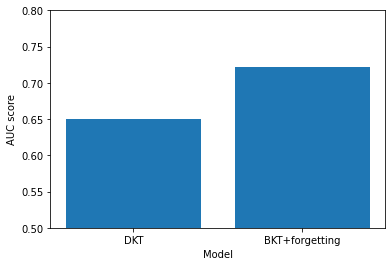

In [ ]:
# Plot results
labels = ['DKT', 'BKT+forgetting']
scores = [dkt_auc, bkt_forgetting_auc]

x_pos = np.arange(len(labels))
plt.bar(x_pos, scores)
plt.xticks(x_pos, labels)
plt.xlabel('Model')
plt.ylabel('AUC score')
plt.ylim(.5, .8)
plt.show()

# Part 3: Actionable insights from knowledge tracing models

### Q 3.1:  Analyze how time taken affects learning
Train a BKT model to analyze how the time taken by a student to submit an answer affects their learning.

Hint: Use `multilearn` parameter from pyBKT library.

- Transform the numerical feature 'timeTaken' into 10 categories using bucketing / binning - `<0s,10s>, <10s,20s>, ..., <80s,90s>, <90s, inf>`
- Train BKT model considering these buckets.
- Use provided code to create a bar plot of the learned parameter $P(\text{L})$ for each time taken category. 
- Compare and contrast parameters across three skills
- Could a course intstructor improve / change the problem set or learning interface based on these insights? If yes, how?

*Hint:* `dataframe.map(dictionary)` can help you map values to other values as given by `dictionary` in Python.

Answer:
* Compare and contrast parameters across three skills: 
  * The probability learn for division and fraction decimals percents is lower than other two skills, which means they are more difficult than other skills. A longer time span for the interaction increases the probability to learn fraction-decimals-percents and least-common-multiple. 
  
* Could a course intstructor improve / change the problem set or learning interface based on these insights? If yes, how?
  * Yes
  * The instructor can give more division and fraction decimals percents questions to make students practice more on these questions. Besides, the instructor can also extend the time limit for fraction-decimals-percents and least-common-multiple questions. 

In [11]:
# ADD CODE HERE
dataset_copy = dataset.copy()
dataset_copy['timeTaken'] = np.digitize(dataset_copy['timeTaken'], bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, np.inf]) - 1
model = Model(seed = SEED, parallel = True)
model.fit(data=dataset_copy, skills=SKILLS, multilearn='timeTaken') 

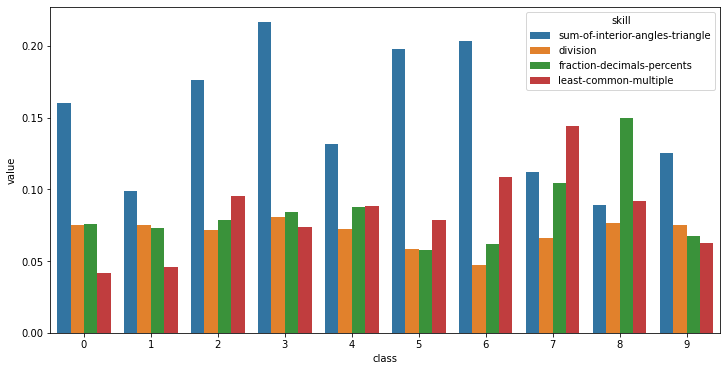

In [12]:
# Visualization code
params = model.params().reset_index()

import seaborn as sns

plt.figure(figsize = (12, 6))
sns.barplot(data=params[params['param'] == 'learns'], x="class", y="value", hue="skill")

### Q 3.2: Analyze learning curves of trained BKT model
The aggregated model metrics above do not tell us anything about the performance for an individual knowledge component. Let's analyze performance across the knowledge components now. A learning curve is plot which shows the average value of mastery vs the number of learner opportunities to train the skill. Our intuition is that different knowledge components differ in their difficulty of mastering. Let's use the BKT and explore the learning curves to analyze it.

Run the code below and discuss following topics:
- Discuss and compare learning curves for three skills. 
- Is the model fitting the ground-truth data well? Compare BKT and BKT+forgetting curves.
- Can you provide insights for a teacher about these knowledge components? 

In [ ]:
# Train BKT model on the full dataset
model = Model(seed=SEED)
%time model.fit(data=dataset) 
model.params()

CPU times: user 184 ms, sys: 2.59 ms, total: 187 ms
Wall time: 131 ms


value
skill                           param   class          
sum-of-interior-angles-triangle prior   default 0.28809
                                learns  default 0.14767
                                guesses default 0.12901
                                slips   default 0.16012
                                forgets default 0.00000
division                        prior   default 0.55301
                                learns  default 0.07822
                                guesses default 0.36850
                                slips   default 0.17311
                                forgets default 0.00000
fraction-decimals-percents      prior   default 0.17471
                                learns  default 0.08361
                                guesses default 0.36794
                                slips   default 0.20293
                                forgets default 0.00000
least-common-multiple           prior   default 0.10539
                                learns  default 0.11459
                                guesses default 0.14591
                                slips   default 0.07381
                                forgets default 0.00000

In [ ]:
# Train BKT model with forgetting
model_forgetting = Model(seed=SEED)
%time model_forgetting.fit(data=dataset, forgets=True)
model_forgetting.params()

CPU times: user 160 ms, sys: 559 µs, total: 161 ms
Wall time: 103 ms


value
skill                           param   class          
sum-of-interior-angles-triangle prior   default 0.26292
                                learns  default 0.19406
                                guesses default 0.11928
                                slips   default 0.09799
                                forgets default 0.04113
division                        prior   default 0.58150
                                learns  default 0.28779
                                guesses default 0.21786
                                slips   default 0.06249
                                forgets default 0.17269
fraction-decimals-percents      prior   default 0.20589
                                learns  default 0.09882
                                guesses default 0.35650
                                slips   default 0.20426
                                forgets default 0.03068
least-common-multiple           prior   default 0.18296
                                learns  default 0.23654
                                guesses default 0.06249
                                slips   default 0.09250
                                forgets default 0.24845

In [ ]:
# Run inference on the same dataset - we will later use it to visually see how good the model is fitting to the data
predictions = model.predict(data=dataset)[['user_id', 'skill_name', 'correct', 'correct_predictions']]
# Rename the dataframe columns as per instructions
predictions.columns = ['user_id', 'skill_name', 'y_ground_truth', 'y_prediction_bkt']

predictions['y_prediction_bkt+forgetting'] = model_forgetting.predict(data=dataset)['correct_predictions']

Plot learning curves of ground truth data and BKT model predictions. Blue curve is based on the ground truth data and contains confidence intervals. Green curve is computed based on BKT model and red curve based on BKT+forgetting model.

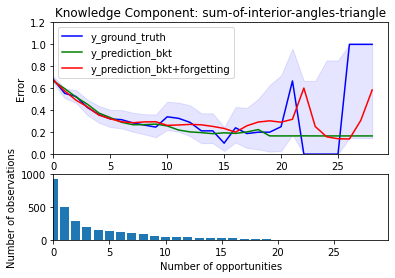

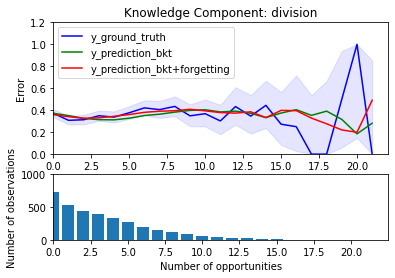

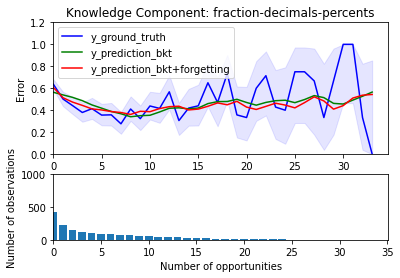

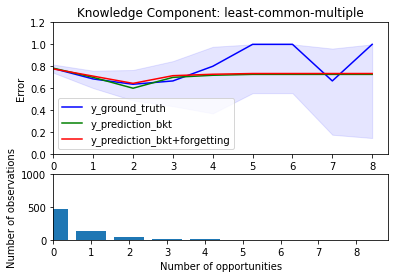

In [ ]:
# Plot learning curves for the model
# Adapted from pyAFM plot_datashop.py - do not change

from pyafm.plot_datashop import avg_y_by_x

colors = {"y_ground_truth": "blue", "y_prediction_bkt": "green", "y_prediction_bkt+forgetting": "red"}
for plot_id, skill_name in enumerate(SKILLS):
    preds = predictions[predictions['skill_name'] == skill_name]
    xp = []
    yp = {}
    
    for col in preds.columns: 
        if 'y_' in col:
            yp[col] = []

    for user_id in preds['user_id'].unique(): 
        user_preds = preds[preds['user_id'] == user_id] 
        xp += list(np.arange(len(user_preds))) 
        for col in preds.columns: 
            if 'y_' in col: 
                yp[col] += user_preds[col].tolist() 

    fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 2]}) 
    lines = []
    for col in preds.columns:
        if 'y_' in col:    
            # compute mean and confidence intervals
            x, y, lcb, ucb, n_obs = avg_y_by_x(xp, yp[col]) 
            y = [1-v for v in y] 
            if col == 'y_ground_truth': 
                axs[0].fill_between(x, lcb, ucb, alpha=.1, color=colors[col])
            model_line, = axs[0].plot(x, y, label=col, color=colors[col]) 
            lines.append(model_line) 

    axs[0].set_title("Knowledge Component: {}".format(skill_name))
    axs[0].legend(handles=lines)
    axs[0].set_ylabel('Error')
    axs[0].set_ylim(0, 1.2)
    axs[0].set_xlim(0, None)

    axs[1].set_xlabel('Number of opportunities')
    axs[1].bar([i for i in range(len(n_obs))], n_obs)
    axs[1].set_ylabel('Number of observations')
    axs[1].set_ylim(0, 1000)
    axs[1].set_xlim(0, None)
    plt.show()

Answer:
- Discuss and compare learning curves for three skills. 
  * For sum-of-interior angle triangle, the error rate decreases as the number of opportunities increases. For other skills, the error rate first decreases then increases as the number of opportunities increases. For fraction-decimal-percents and division skills, the fluctuation of the error rate increases as the opportunites number goes larger (might caused by the decreasing number of observations). The faster decrease (such as sum-of-interior-angle) means the skill is relatively easier to learn. 

- Is the model fitting the ground-truth data well? Compare BKT and BKT+forgetting curves.
  * The model fitting the ground-truth well when there is less opportunities. For large number opportunities cases, the variance is increased since the observation is decreasing. 
  * For sum-of-interior-angle skill the BKT + forgetting has better performance (or overfit the data). However, for other three skills, the two methods have similar performance. 

- Can you provide insights for a teacher about these knowledge components? 
  * Generouly, the error rate decreases as the number of opportunity increases. The teachers can find the optimal number of opportunities for different knowledge components to achieve the lowest error rate. This information could be helpful for choosing the number of practicing times. 

### Q 3.3: Use knowledge tracing model for downstream tasks
Knowledge tracing model is usually not the final goal in EDM. Definition of knowledge components are important for reaching high quality models for the downstream tasks. However, suitable mappings can be difficult to find and often require researchers to iteratively test mappings to see which better fits the student data. For a more detailed analysis of knowldege component please refer to knowledge-learning-instruction framework (Koedinger 2012). 
Answer the following questions: 
- 1) List some examples of downstream tasks which can benefit from knowledge tracing models. Pick one example and describe how the output of the knowledge tracing model could be incorporated in the downstream model in more detail (How can the output be interpreted when designing the downstream task? Does the output of the knowledge tracing need to be transformed?).
- 2) Compare and discuss the impact of granularity of knowledge component on a) knowledge tracing models and b) student learning. Imagine a following simple scenario with math task / question: `A vase can hold 9 flowers. If you had 4 carnations and 23 roses, how many vases would you need to hold the flowers?` and consider these knowledge component annotations:
    - Example 1: division, addition, three variables, within 100
    - Example 2: arithmetic with more than two variables
    - Example 3: math word problems

Answer:
1. Downstream tasks:
  * Examples: 
    * Improvement on this task means that resources can be suggested to students based on their individual needs.
    * Content which is predicted to be too easy or too hard can be skipped or delayed.
    * The system can select best number of opportunities for the knowledge.
    
  * For eample, the trained BKT model contains parameters such as probability of mastering the corresponding knowledge. This probability can be used to identify which knowledge is more difficult for the student. And the system can suggest more resources for the difficult knowledge. 
  * The output (probability learn) needs to be specified for each students.
2. If the knowledge component is divided to rough, like in example 3, the performance will be bad since the model cannot learn different skills. However, it the component is divided to detaily, like in example 1, the performane is also bad since the model cannot be generalized. Like in example 2, the performance of knoledge tracing models will be better since there are suitable knowledge components parameters in the model (we assmue the dataset is large enough). It is also beneficial for student learning if the system can divide the knowledge in more detailed steps. 

*End of the assignment.
Congratulations on finishing assignment 2.1.*